In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# Importando conjunto de dados
path = r'predictive_maintenance.csv'
data = pd.read_csv(path)
data.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [3]:
#verificando tipos de cada coluna
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [4]:
#Obtendo métricas para dados numéricos
data.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [5]:
#Verificando se existem valores em branco
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [6]:
#Obtendo todos os tipos de falha
data['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [7]:
#verificando consistencia entre Target e Failure type
#Verificando quando há falha
df_failure = data[data['Target'] == 1].copy()
df_failure['Failure Type'].value_counts()

#Existem 9 falhas com o tipo de falha = sem falha

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

In [8]:
#Removendo inconsistências
data = data[~((data['Target'] == 1) & (data['Failure Type'] == 'No Failure'))]
df_failure = data[data['Target'] == 1].copy()
df_failure['Failure Type'].value_counts()

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Name: count, dtype: int64

In [9]:
#Verificando quando não há falha
df_failure = data[data['Target'] == 0]
df_failure['Failure Type'].value_counts()

Failure Type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

In [10]:
#Removendo mais inconsistências
data = data[~((data['Target'] == 0) & (data['Failure Type'] == 'Random Failures'))]
df_failure = data[data['Target'] == 0].copy()
df_failure['Failure Type'].value_counts()

Failure Type
No Failure    9643
Name: count, dtype: int64

In [11]:
data.shape[0]

9973

array([[<Axes: title={'center': 'Air temperature [K]'}>,
        <Axes: title={'center': 'Process temperature [K]'}>],
       [<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>],
       [<Axes: title={'center': 'Tool wear [min]'}>,
        <Axes: title={'center': 'Target'}>]], dtype=object)

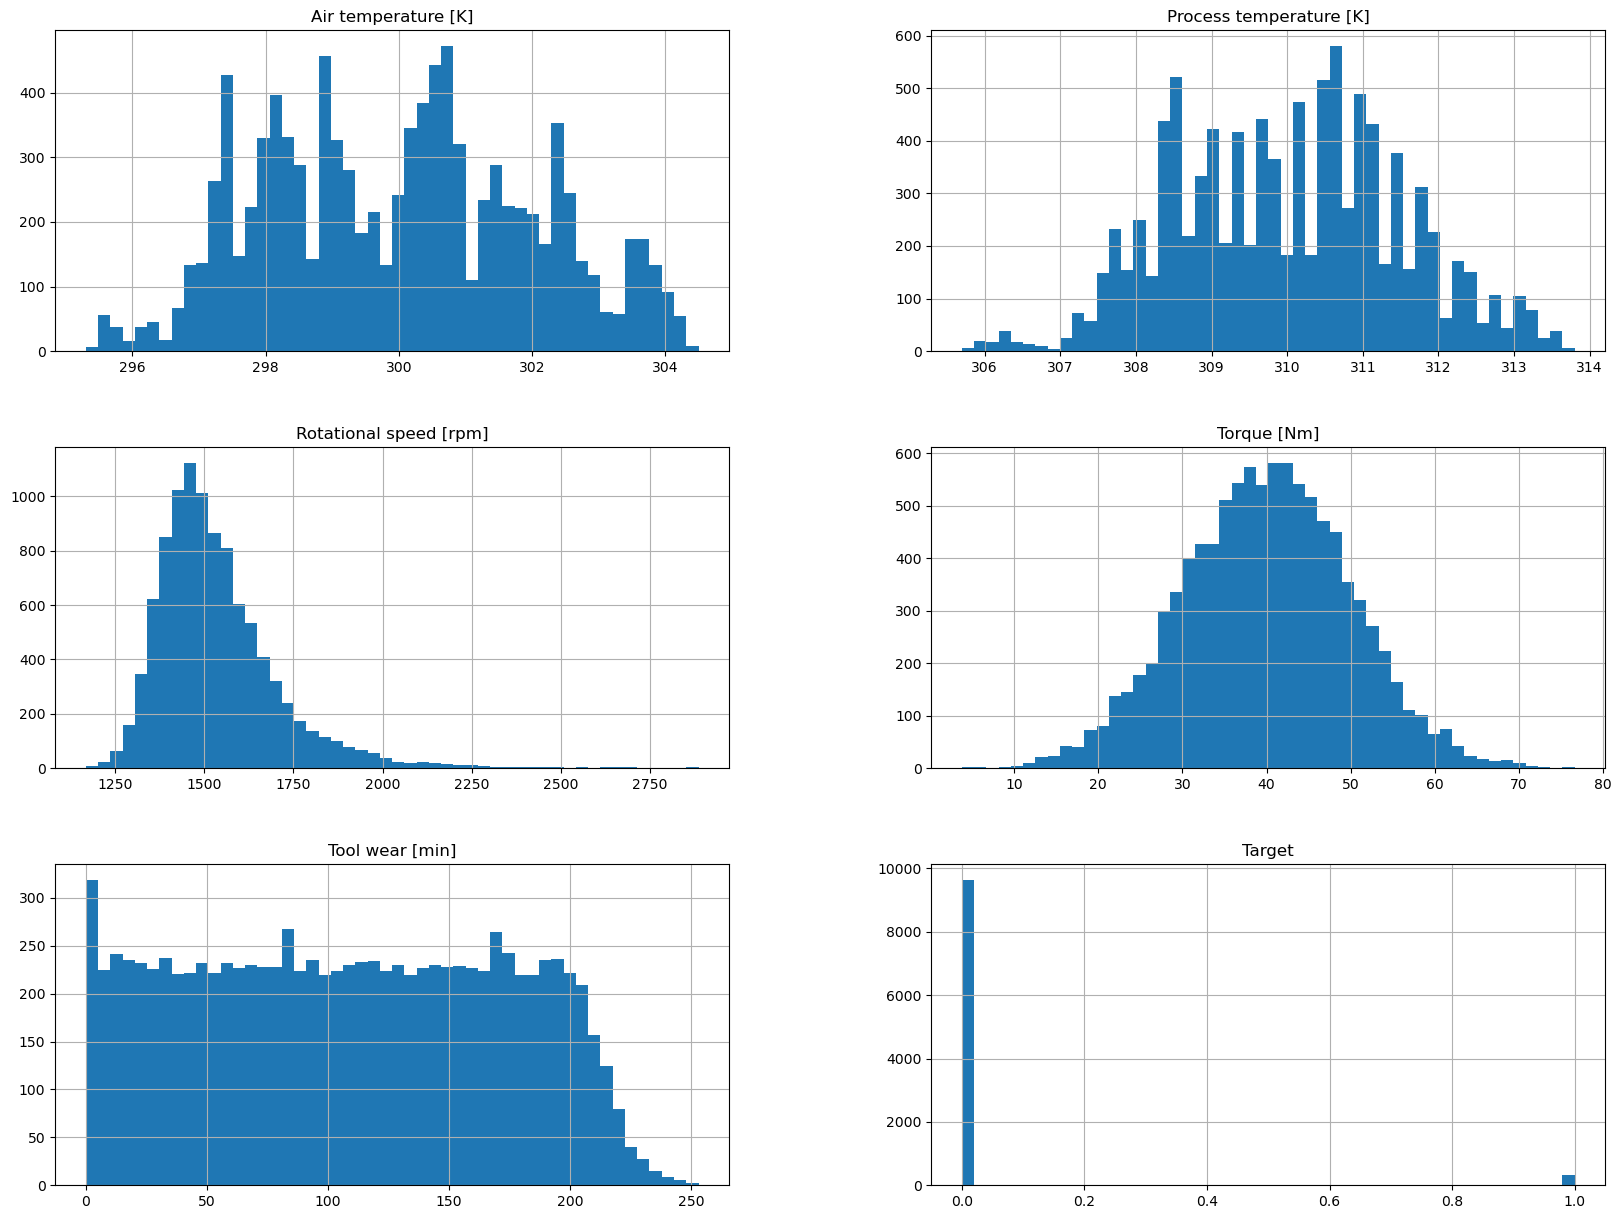

In [12]:
#Histograma das colunas numéricas
data = data.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)
data.hist(bins=50, figsize = (20,15))

#Tool wear tem uma distribuição uniforme, mas começa haverem cada vez menos instancias após 200 min. Parece indicar que o equipamento começa a falhar após esse período de uso.

#Outra observação é que a distribuição de Target (variável alvo) mostra que o dataset é muito desbalanceado, com uma classe muito desproporcional à outra.

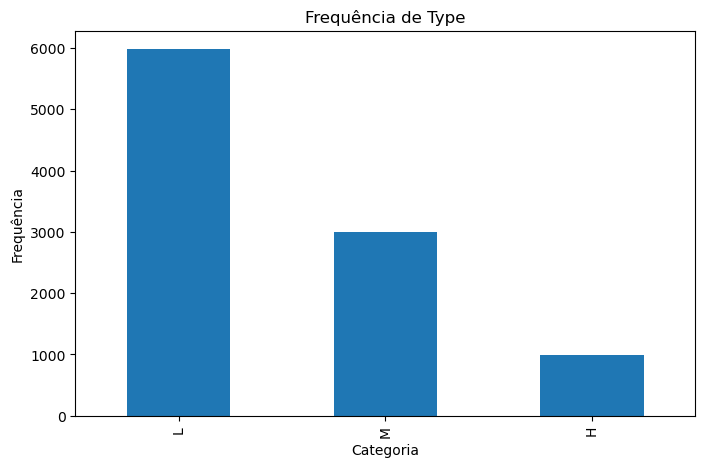

In [13]:
#Gráfico de barras da coluna Type
contagem_ocorrencias = data['Type'].value_counts()
plt.figure(figsize=(8,5))
contagem_ocorrencias.plot(kind='bar')
plt.title('Frequência de Type')
plt.xlabel('Categoria')
plt.ylabel('Frequência')
plt.show()

In [14]:
# Mapeamento personalizado de categorias para números
mapeamento = {'L': 1, 'M': 2, 'H': 3}

# Transformando os valores categóricos em números usando o mapeamento
data['Type'] = data['Type'].map(mapeamento)

data.head(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,298.1,308.6,1551,42.8,0,0
1,1,298.2,308.7,1408,46.3,3,0
2,1,298.1,308.5,1498,49.4,5,0
3,1,298.2,308.6,1433,39.5,7,0
4,1,298.2,308.7,1408,40.0,9,0
5,2,298.1,308.6,1425,41.9,11,0
6,1,298.1,308.6,1558,42.4,14,0
7,1,298.1,308.6,1527,40.2,16,0
8,2,298.3,308.7,1667,28.6,18,0
9,2,298.5,309.0,1741,28.0,21,0


In [15]:
#Dividindo o conjunto de dados em treinamento e teste
X = data.drop('Target', axis=1)
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2024)

Train_set = pd.concat([X_train, y_train], axis=1)

In [16]:
#Fazendo oversampling no conjunto de treinamento
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)


In [17]:
#Conjunto de Treinamento após oversampling
Train_set_sm = pd.concat([X_sm, y_sm], axis=1)
Train_set_sm.Target.value_counts()

#Agora temos o mesmo número de amostras para ambos os valores de Target

Target
0    8678
1    8678
Name: count, dtype: int64

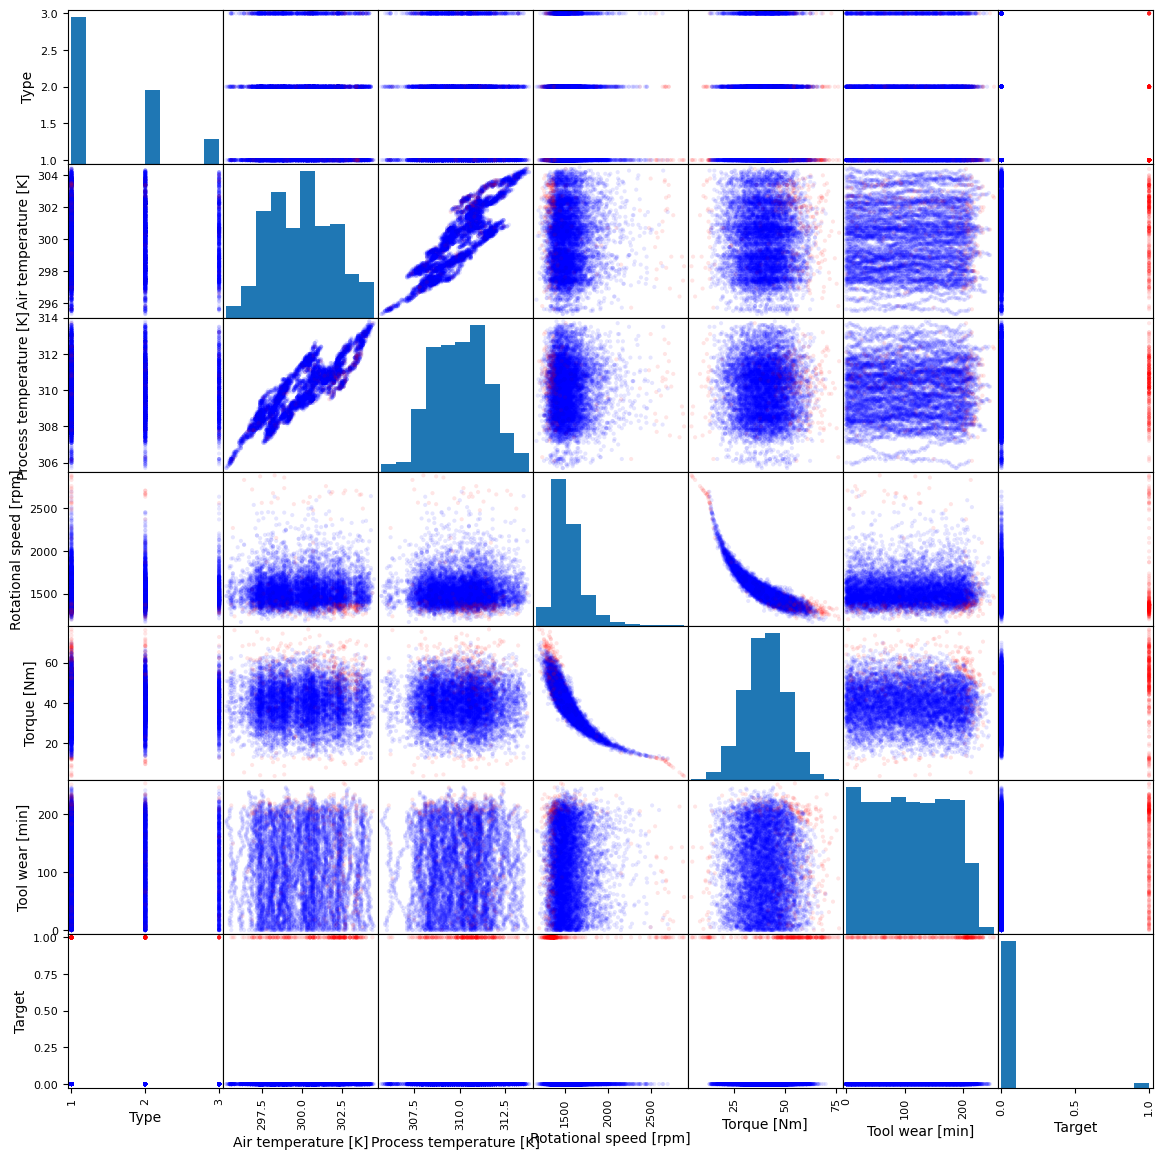

In [18]:
# Scatter matrix com cores diferentes para target=0 (azul) e target=1 (vermelho) no conjunto de treinamento original
# Vermelho = Falha
colors = Train_set['Target'].map({0: 'blue', 1: 'red'})
scatter_matrix_out = scatter_matrix(Train_set, figsize=(14, 14), diagonal='hist', color=colors, alpha = 0.1)
plt.show()

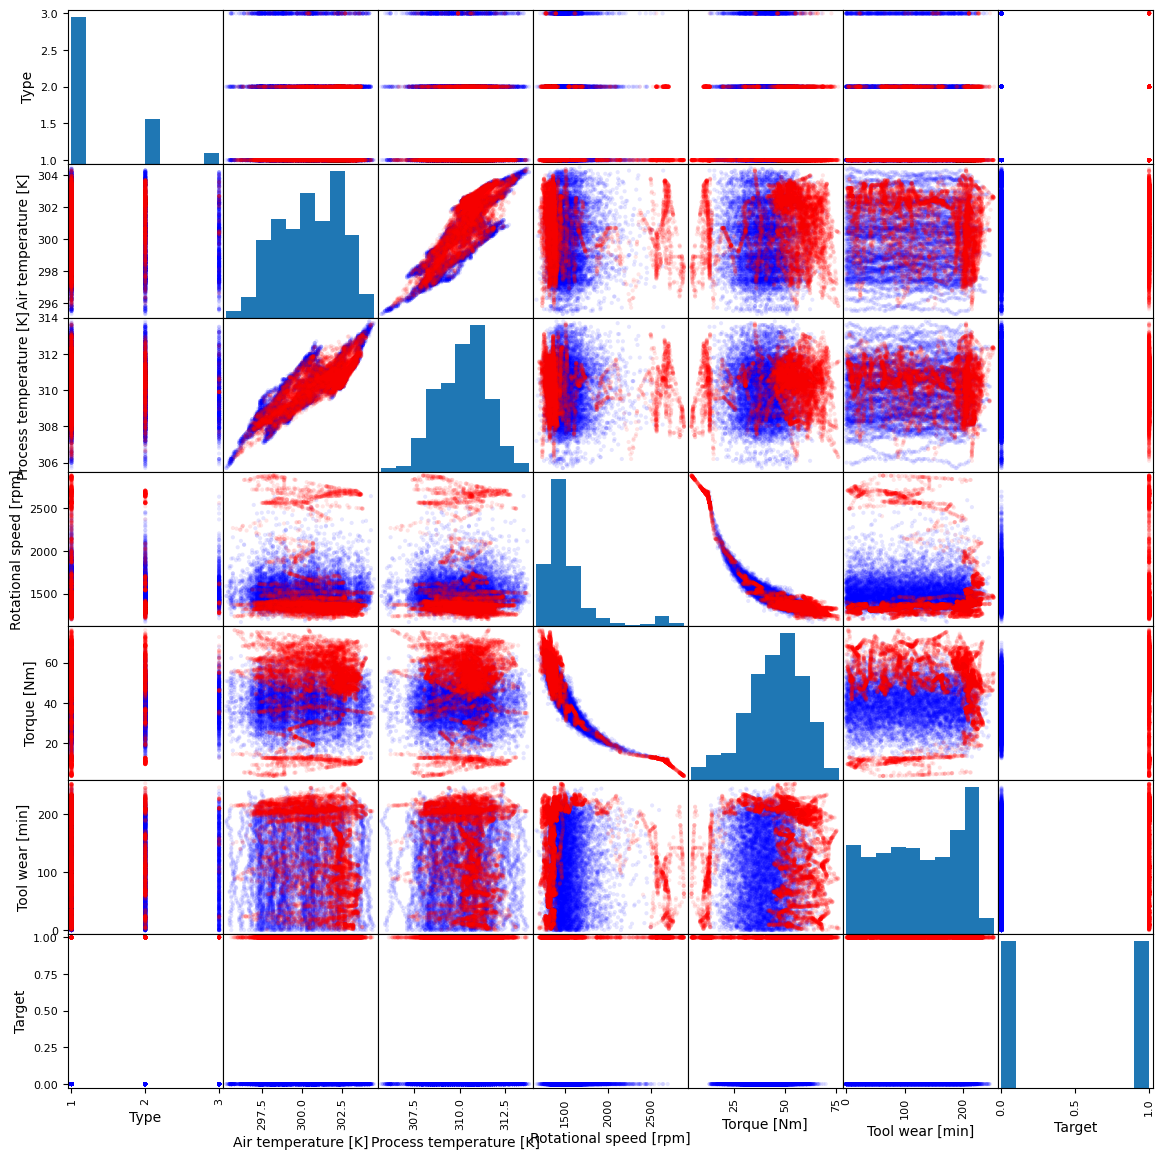

In [19]:
# Scatter matrix com cores diferentes para target=0 (azul) e target=1 (vermelho) após oversampling
# Vermelho = Falha
colors = Train_set_sm['Target'].map({0: 'blue', 1: 'red'})
scatter_matrix_out_sm = scatter_matrix(Train_set_sm, figsize=(14, 14), diagonal='hist', color=colors, alpha = 0.1)
plt.show()

#Nos extremos de Torque/V. de rotação, a máquina tende a falhar
#Na região de 200 min de Tool Wear também

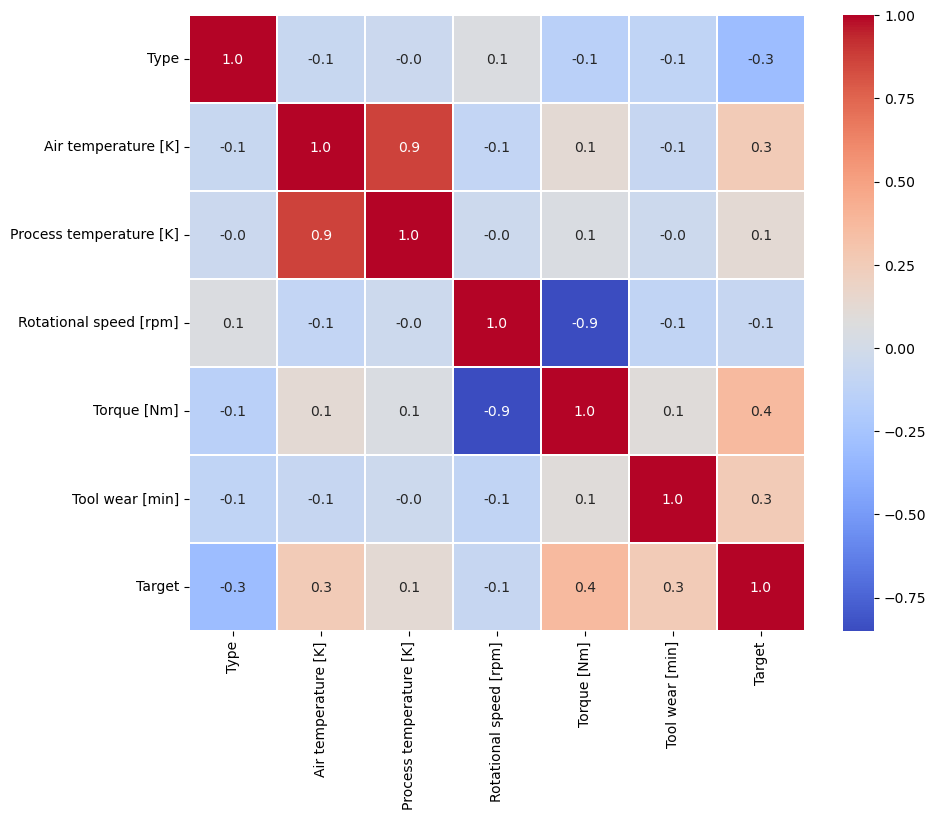

In [20]:
#Matriz de correlação entre as variáveis após oversampling
corr_matrix = Train_set_sm.corr(numeric_only = True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, linewidth=.1, fmt='.1f', cmap='coolwarm', square=True, cbar=True, annot=True)
plt.show()

# Os pares de variáveis (Process Temperature, Air temperature) e (Trque, Rotation Speed) apresentam correlação muito forte entre si. Isso pode confundir o modelo. 
# Lembrar de experimentar remover a com menor correlação com target de cada par e ver se melhora o desempenho

In [21]:
# Criando o ColumnTransformer
Scaling = ColumnTransformer(
    transformers=[('minmax1', MinMaxScaler(), ['Air temperature [K]']),
                  ('minmax2', MinMaxScaler(), ['Process temperature [K]']),
                  ('robust', RobustScaler(), ['Rotational speed [rpm]']),
                  ('standard', StandardScaler(), ['Torque [Nm]']),
                  ('minmax3', MinMaxScaler(), ['Tool wear [min]'])],
    remainder='passthrough')



In [22]:
# Inicializando variáveis para armazenar os resultados dos modelos
index = []
results = {'Roc Auc': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}

In [23]:
# Logistic Regression
#StandardScaler demora muito tempo. Em modelos baseados em Decision Trees, podemos retira-lo sem causar problemas.
steps = [('scaling', Scaling), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# Guardando o resultado em um DataFrame
index += ["Logistic Regression"]
results["Roc Auc"].append(scores["test_roc_auc"].mean())
results["Accuracy"].append(scores["test_accuracy"].mean())
results["Precision"].append(scores["test_precision"].mean())
results["Recall"].append(scores["test_recall"].mean())
results["F1"].append(scores["test_f1"].mean())

df_results = pd.DataFrame(results, index=index)
df_results

,Roc Auc,Accuracy,Precision,Recall,F1
Logistic Regression,0.897112,0.971365,0.79631,0.193333,0.296633


In [24]:
# Random Forest
#StandardScaler demora muito tempo. Em modelos baseados em Decision Trees, podemos retira-lo sem causar problemas.
steps = [('scaling', Scaling), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# Guardando o resultado em um DataFrame
index += ["Random Forest"]
results["Roc Auc"].append(scores["test_roc_auc"].mean())
results["Accuracy"].append(scores["test_accuracy"].mean())
results["Precision"].append(scores["test_precision"].mean())
results["Recall"].append(scores["test_recall"].mean())
results["F1"].append(scores["test_f1"].mean())

df_results = pd.DataFrame(results, index=index)
df_results


,Roc Auc,Accuracy,Precision,Recall,F1
Logistic Regression,0.897112,0.971365,0.79631,0.193333,0.296633
Random Forest,0.972286,0.985404,0.89438,0.633793,0.738026


In [25]:
# XGBoost
steps = [('scaling', Scaling), ('model', XGBClassifier())]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# Guardando o resultado em um DataFrame
index += ["XGBClassifier"]
results["Roc Auc"].append(scores["test_roc_auc"].mean())
results["Accuracy"].append(scores["test_accuracy"].mean())
results["Precision"].append(scores["test_precision"].mean())
results["Recall"].append(scores["test_recall"].mean())
results["F1"].append(scores["test_f1"].mean())

df_results = pd.DataFrame(results, index=index)
df_results

,Roc Auc,Accuracy,Precision,Recall,F1
Logistic Regression,0.897112,0.971365,0.796310,0.193333,0.296633
Random Forest,0.972286,0.985404,0.894380,0.633793,0.738026
XGBClassifier,0.984077,0.984958,0.833369,0.687011,0.750764


In [26]:
# Logistic Regression + SMOTE
#StandardScaler demora muito tempo. Em modelos baseados em Decision Trees, podemos retira-lo sem causar problemas.
steps = [('over', SMOTE()), ('scaling', Scaling), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# Guardando o resultado em um DataFrame
index += ["Logistic Regression + SMOTE"]
results["Roc Auc"].append(scores["test_roc_auc"].mean())
results["Accuracy"].append(scores["test_accuracy"].mean())
results["Precision"].append(scores["test_precision"].mean())
results["Recall"].append(scores["test_recall"].mean())
results["F1"].append(scores["test_f1"].mean())

df_results = pd.DataFrame(results, index=index)
df_results

,Roc Auc,Accuracy,Precision,Recall,F1
Logistic Regression,0.897112,0.971365,0.796310,0.193333,0.296633
Random Forest,0.972286,0.985404,0.894380,0.633793,0.738026
XGBClassifier,0.984077,0.984958,0.833369,0.687011,0.750764
Logistic Regression + SMOTE,0.902843,0.841222,0.146690,0.784828,0.246978


In [27]:
# Random Forest
# Implementando SMOTE dentro da validação cruzada
steps = [('over', SMOTE()), ('scaling', Scaling), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# Guardando o resultado em um DataFrame
index += ["Random Forest + SMOTE"]
results["Roc Auc"].append(scores["test_roc_auc"].mean())
results["Accuracy"].append(scores["test_accuracy"].mean())
results["Precision"].append(scores["test_precision"].mean())
results["Recall"].append(scores["test_recall"].mean())
results["F1"].append(scores["test_f1"].mean())

df_results = pd.DataFrame(results, index=index)
df_results

,Roc Auc,Accuracy,Precision,Recall,F1
Logistic Regression,0.897112,0.971365,0.796310,0.193333,0.296633
Random Forest,0.972286,0.985404,0.894380,0.633793,0.738026
XGBClassifier,0.984077,0.984958,0.833369,0.687011,0.750764
Logistic Regression + SMOTE,0.902843,0.841222,0.146690,0.784828,0.246978
Random Forest + SMOTE,0.977447,0.964457,0.479638,0.784828,0.594724


In [28]:
# XGBoost + SMOTE
steps = [('over', SMOTE()), ('scaling', Scaling), ('model', XGBClassifier())]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# Guardando o resultado em um DataFrame
index += ["XGBClassifier + SMOTE"]
results["Roc Auc"].append(scores["test_roc_auc"].mean())
results["Accuracy"].append(scores["test_accuracy"].mean())
results["Precision"].append(scores["test_precision"].mean())
results["Recall"].append(scores["test_recall"].mean())
results["F1"].append(scores["test_f1"].mean())

df_results = pd.DataFrame(results, index=index)
df_results

,Roc Auc,Accuracy,Precision,Recall,F1
Logistic Regression,0.897112,0.971365,0.796310,0.193333,0.296633
Random Forest,0.972286,0.985404,0.894380,0.633793,0.738026
XGBClassifier,0.984077,0.984958,0.833369,0.687011,0.750764
Logistic Regression + SMOTE,0.902843,0.841222,0.146690,0.784828,0.246978
Random Forest + SMOTE,0.977447,0.964457,0.479638,0.784828,0.594724
XGBClassifier + SMOTE,0.978473,0.973035,0.570177,0.808391,0.666088


In [29]:
#Sem variaveis correlacionadas
X_train_corr = X_train[['Type', 'Air temperature [K]', 'Torque [Nm]', 'Tool wear [min]']]

# Criando o ColumnTransformer
Scaling_less_features = ColumnTransformer(
    transformers=[('minmax1', MinMaxScaler(), ['Air temperature [K]']),
                  ('standard', StandardScaler(), ['Torque [Nm]']),
                  ('minmax3', MinMaxScaler(), ['Tool wear [min]'])],
    remainder='passthrough')


In [30]:
# Sem SMOTE e Sem variaveis correlacionadas
steps = [('scaling', Scaling_less_features), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(pipeline, X_train_corr, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# Guardando o resultado em um DataFrame
index += ["RandomForest less Features"]
results["Roc Auc"].append(scores["test_roc_auc"].mean())
results["Accuracy"].append(scores["test_accuracy"].mean())
results["Precision"].append(scores["test_precision"].mean())
results["Recall"].append(scores["test_recall"].mean())
results["F1"].append(scores["test_f1"].mean())

df_results = pd.DataFrame(results, index=index)
df_results

,Roc Auc,Accuracy,Precision,Recall,F1
Logistic Regression,0.897112,0.971365,0.796310,0.193333,0.296633
Random Forest,0.972286,0.985404,0.894380,0.633793,0.738026
XGBClassifier,0.984077,0.984958,0.833369,0.687011,0.750764
Logistic Regression + SMOTE,0.902843,0.841222,0.146690,0.784828,0.246978
Random Forest + SMOTE,0.977447,0.964457,0.479638,0.784828,0.594724
XGBClassifier + SMOTE,0.978473,0.973035,0.570177,0.808391,0.666088
RandomForest less Features,0.937993,0.978050,0.802027,0.451264,0.574411


In [31]:
'''
Lembrar:
#1 obter outras métricas de desempenho -> F1 Score, precisão, revocação, acurácia
#2 hyperparameter tunning com hyperopt
#3 Implementar outros algoritmos -> Xgboost, Random Forests, 
#4 Testar modelos prontos no conjunto de teste
'''
XGBClassifier

xgboost.sklearn.XGBClassifier